<a href="https://colab.research.google.com/github/kashyap333/Playground_Series_Season_3-_Episode_3/blob/main/Playground_Series_Season_3%2C_Episode_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c playground-series-s3e3


In [ ]:
!unzip playground-series-s3e3

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessClassifier
from pandas import get_dummies
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [57]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
train.head()

In [ ]:
train.info()

In [ ]:
train.select_dtypes(include='object').columns

In [ ]:
train.select_dtypes(include='int').columns

In [58]:
y_train = train['Attrition']
X = train.drop('Attrition', axis=1)

In [59]:
def preprocessing(data):
  'Pass dataframe with no Attrition column'

  data.drop('id', axis=1, inplace = True)
  for col in data.columns:
    if len(data[col].unique()) < 2:
      data.drop(col, axis=1, inplace = True)

  data = pd.get_dummies(data)
  X = pd.DataFrame(StandardScaler().fit_transform(data), index=data.index, columns=data.columns)
      
  return X
  

In [60]:
X_train = preprocessing(X)
X_test = preprocessing(test)

In [61]:
X_train.shape, X_test.shape, y_train.shape

((1677, 51), (1119, 51), (1677,))

In [62]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

In [63]:
class train(Dataset):
  def __init__(self, X_train, y_train):

    self.X_train = torch.from_numpy(X_train.values.astype(np.float32))
    self.y_train = torch.from_numpy(y_train.values.astype(np.float32))

  def __len__(self):
    return len(self.X_train)

  def __getitem__(self, id):
    return self.X_train[id], self.y_train[id]


In [64]:
class aug_test(Dataset):
  def __init__(self, x_test):
    
    self.X_test = torch.from_numpy(x_test.values.astype(np.float32))
  

  def __len__(self):
    return len(self.X_test)

  def __getitem__(self, idx):
    return self.X_test[idx]

In [65]:
X = train(X_train, y_train)

In [66]:
X_test = aug_test(X_test)

In [67]:
X_dataloader = DataLoader(X, batch_size=64, shuffle=True)
test_dataloader = DataLoader(X_test, batch_size=64)

In [68]:
data, label = next(iter(X_dataloader))
data[0], label[0]

(tensor([-0.9450,  1.1759,  1.9576,  0.0597, -0.6976, -0.4528, -1.2027, -0.9225,
          0.1897, -0.8038, -0.7975, -0.6351,  2.3676,  2.6147,  1.1588,  0.3612,
         -1.3387, -0.6401,  0.3555, -0.9873, -0.8777, -0.6498, -1.1710, -0.2850,
         -0.4293,  0.5477, -0.1543,  0.6611, -0.6249, -0.0884, -0.9269, -0.3157,
         -0.6976,  4.4104, -0.2598, -0.7590,  0.7590, -0.3191, -0.1439, -0.4987,
         -0.2662, -0.3638, -0.2103,  1.9685, -0.5182, -0.2194,  2.0319, -0.9247,
         -0.7243, -1.7868,  1.7868]), tensor(1.))

In [97]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Linear(in_features=51, out_features=128)
    self.layer2 = nn.Linear(in_features=128, out_features=96)
    self.layer3 = nn.Linear(in_features=96, out_features=64)
    self.layer4 = nn.Linear(in_features=64, out_features=32)
    self.layer5 = nn.Linear(in_features=32, out_features=16)
    self.layer6 = nn.Linear(in_features=16, out_features=1)

    self.relu = nn.LeakyReLU()
    self.batch_norm1 = nn.BatchNorm1d(128)
    self.batch_norm2 = nn.BatchNorm1d(96) 
    self.batch_norm3 = nn.BatchNorm1d(64) 
    self.batch_norm4 = nn.BatchNorm1d(32)
    self.batch_norm5 = nn.BatchNorm1d(16)
    self.sigmoid = nn.Sigmoid()
    self.drop = nn.Dropout1d(p=0.5)
     

  def forward(self, x: torch.tensor):

    x = self.batch_norm1(self.layer1(x))
    x = self.batch_norm2(self.layer2(x))
    x = self.drop(x)
    x = self.batch_norm3(self.layer3(x))
    x = self.batch_norm4(self.layer4(x))
    x = self.drop(x)
    x = self.relu(self.batch_norm5(self.layer5(x)))
    x = self.sigmoid(self.layer6(x))

    return x

torch.manual_seed(42)

model = Model()
#model, model.state_dict()


In [98]:
model.to(device)
next(model.parameters()).device

device(type='cpu')

In [104]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [103]:
torch.manual_seed(42)

loss_value = []
epoch_no = []
epochs = 500



for epoch in range(epochs+1):
  model.train()
  for x_train, y_train in X_dataloader:
    
    x_train = x_train.to(device)
    y_train = y_train.to(device)

    y_pred = model(x_train)

    loss = loss_fn(y_pred, y_train.unsqueeze(1))

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()



  if epoch % 50 == 0:
    print(f'Epoch: {epoch} | Loss: {loss}')
    loss_value.append(loss.detach().cpu().numpy())
    epoch_no.append(epoch)

Epoch: 0 | Loss: 0.25158044695854187
Epoch: 50 | Loss: 0.24988184869289398
Epoch: 100 | Loss: 0.5891695618629456
Epoch: 150 | Loss: 0.19362381100654602
Epoch: 200 | Loss: 0.42581307888031006
Epoch: 250 | Loss: 0.33909210562705994
Epoch: 300 | Loss: 0.5589013695716858
Epoch: 350 | Loss: 0.32052165269851685
Epoch: 400 | Loss: 0.3113812208175659
Epoch: 450 | Loss: 0.34335973858833313
Epoch: 500 | Loss: 0.4586380422115326


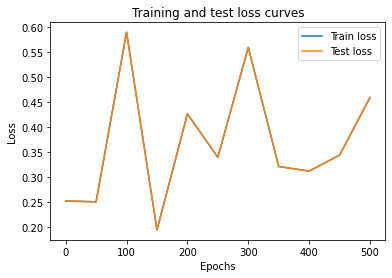

In [105]:
plt.plot(epoch_no, loss_value, label="Train loss")
plt.plot(epoch_no, loss_value, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();
     

In [106]:
test_loss = []

model.eval()
for x_test in test_dataloader:
  x_test = x_test.to(device)
  with torch.inference_mode():
    test_pred = model(x_test)
    test_pred_value = test_pred.cpu().numpy()
    

    test_loss.append(test_pred_value)

In [107]:
final_probs = [item for sublist in test_loss for item in sublist]

     

result = []
for i in range(len(final_probs)):
  result.append(final_probs[i][0])

In [108]:
test = pd.read_csv('test.csv')
results = pd.DataFrame(test.id)
results['Attrition'] = result
result = results.to_csv('result.csv', index=False)

In [109]:
!kaggle competitions submit -c playground-series-s3e3 -f result.csv -m "Pytorch"

100% 17.6k/17.6k [00:01<00:00, 14.8kB/s]
400 - Bad Request
